## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings

warnings.filterwarnings("ignore")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Load Data

In [3]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [4]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [5]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [6]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [7]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

In [9]:
max(df.groupby("permno_id")["ticker"].nunique())

3

In [10]:
# Group by 'PERMNO' and count unique 'TICKER', then filter for those with exactly 2 unique 'TICKER'
permno_with_multiple_tickers = df.groupby("permno_id")["ticker"].nunique()
permno_with_multiple_tickers = permno_with_multiple_tickers[permno_with_multiple_tickers == 2].index

# Display the PERMNO values
# data[data['PERMNO'].isin(permno_with_multiple_tickers)]
permno_with_multiple_tickers

Index(['10696', '12431', '13407', '14882', '16048', '16692', '16851', '17830',
       '19751', '24053', '24643', '25582', '42200', '52329', '57568', '62308',
       '64282', '67598', '71563', '75034', '76082', '81540', '82303', '86783',
       '89017', '89179', '90199', '90441', '90442', '91277'],
      dtype='object', name='permno_id')

In [11]:
df[df["permno_id"].isin(permno_with_multiple_tickers)]

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
68278,2018-01-02,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,2.802348,0.100099,0.100099,138.64000,0.741796,0.020016,0.020016,0.062708,0.091308,0.249650
68279,2018-01-03,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,2.182780,0.086210,0.086210,139.03000,0.660814,0.018283,0.018283,0.097232,0.094987,0.248987
68280,2018-01-04,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,1.693096,0.073326,0.073326,138.39999,0.405810,0.012239,0.012239,0.082155,0.084828,0.246870
68281,2018-01-05,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,1.827519,0.077066,0.077066,140.45000,0.468490,0.013817,0.013817,0.073817,0.089158,0.248848
68282,2018-01-08,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,1.886495,0.078656,0.078656,142.72000,0.666114,0.018399,0.018399,0.082189,0.088761,0.252631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7140630,2023-12-22,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7140631,2023-12-26,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7140632,2023-12-27,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7140633,2023-12-28,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Feature Engineering

In [12]:
data_1 = df[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data_1

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,336110.0,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,336110.0,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,336110.0,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,336110.0,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]
data_1

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,naics_sector_digits
9263,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310,51
9264,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724,51
9265,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385,51
9266,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463,51
9267,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,336110.0,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33
7656952,2023-12-26,93436,336110.0,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33
7656953,2023-12-27,93436,336110.0,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33
7656954,2023-12-28,93436,336110.0,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33


In [14]:
data_2 = data_1[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data_2

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,336110.0,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,336110.0,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,336110.0,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,336110.0,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Model-Step 1 (Baseline)

In [15]:
data = data_2

In [16]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [17]:
data[-30:]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
7656926,2023-11-16,93436,336110.0,-0.038835,0.038835,-0.000869,-0.004937,-0.001334,0.004114,0.324775,0.324775,0.050085,0.050085,0.026224,0.026224,0.355413,0.288883,0.330446
7656927,2023-11-17,93436,336110.0,0.003035,0.003035,0.002385,0.003949,0.003156,-0.000656,0.235617,0.235617,0.052651,0.052651,0.019067,0.019067,0.371970,0.289036,0.336745
7656928,2023-11-20,93436,336110.0,0.005533,0.005533,0.009430,0.007483,0.007163,0.006781,0.101719,0.101719,0.022650,0.022650,0.000000,0.000000,0.396123,0.300512,0.000000
7656929,2023-11-21,93436,336110.0,0.023491,0.023491,-0.002472,-0.003581,-0.003160,-0.001215,-0.049519,0.049519,-0.022278,0.022278,0.000000,0.000000,0.369358,0.286615,0.000000
7656930,2023-11-22,93436,336110.0,-0.029408,0.029408,-0.001036,0.004794,0.004151,0.004135,0.030445,0.030445,0.027974,0.027974,0.000000,0.000000,0.329192,0.258743,0.000000
7656931,2023-11-24,93436,336110.0,0.005280,0.005280,-0.000404,0.006189,0.000437,0.001657,0.073508,0.073508,0.085981,0.085981,0.000000,0.000000,0.337080,0.325520,0.000000
7656932,2023-11-27,93436,336110.0,0.002672,0.002672,-0.001712,-0.003564,-0.002027,-0.003296,0.073767,0.073767,0.095855,0.095855,0.000000,0.000000,0.337084,0.326089,0.000000
7656933,2023-11-28,93436,336110.0,0.044083,0.044083,-0.000177,-0.008462,0.000747,-0.002023,-0.082184,0.082184,0.028019,0.028019,0.000000,0.000000,0.198041,0.275052,0.000000
7656934,2023-11-29,93436,336110.0,-0.010512,0.010512,0.002796,0.005689,0.000772,-0.001893,-0.006302,0.006302,0.069404,0.069404,0.000000,0.000000,0.193030,0.279782,0.000000
7656935,2023-11-30,93436,336110.0,-0.016770,0.016770,-0.000674,0.003475,0.003368,0.004055,-0.007258,0.007258,0.037967,0.037967,0.000000,0.000000,0.193708,0.326211,0.000000


In [18]:
data.describe()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
count,809883,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000,809883.000000
mean,2021-01-02 19:26:16.187671808,0.000347,0.015239,0.000340,0.000143,0.000335,0.000226,0.062016,0.221782,0.011755,0.075367,0.003473,0.026526,0.299785,0.309311,0.315029
min,2018-01-02 00:00:00,-0.773592,0.000000,-1.949859,-0.510336,-0.129686,-0.095060,-0.999627,0.000000,-0.918449,0.000000,-0.505787,0.000000,0.000000,0.000000,0.000000
25%,2019-07-10 00:00:00,-0.009627,0.004608,-0.006371,-0.006763,-0.005049,-0.005496,-0.119866,0.067578,-0.043232,0.024668,-0.014979,0.008843,0.167155,0.186708,0.200940
50%,2021-01-05 00:00:00,0.000817,0.010260,0.000887,0.000677,0.000743,0.000637,0.024535,0.150276,0.010485,0.054429,0.004058,0.019569,0.243410,0.259283,0.269265
75%,2022-07-01 00:00:00,0.010825,0.019626,0.007900,0.008082,0.007133,0.006488,0.181726,0.279142,0.063910,0.100071,0.023282,0.035404,0.359321,0.363738,0.365940
max,2023-12-29 00:00:00,0.629788,0.773592,4.629079,1.409433,0.090241,0.100972,122.448772,122.448772,4.453196,4.453196,0.758288,0.758288,5.258937,4.398254,3.282485
std,NaN,0.023655,0.018095,0.018470,0.015654,0.013260,0.012536,0.483496,0.434081,0.108734,0.079254,0.037834,0.027200,0.228246,0.212317,0.200876


In [19]:
data[data["log_return_14"] == np.inf]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28


In [20]:
# Check if there are any infinite values in the entire DataFrame
infinite_values = data.isin([np.inf, -np.inf]).values.any()
print(f"Data contains Infinities: {infinite_values}")

# Check for specific columns
column_with_inf = data.isin([np.inf, -np.inf]).any()
print("Columns with Infinities:")
print(column_with_inf[column_with_inf].index.tolist())

Data contains Infinities: False
Columns with Infinities:
[]


In [21]:
data_inf_rows = data[np.isinf(data["log_return_7"])]
data_inf_rows

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28


In [22]:
data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
data[data_inf_rows]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28


In [23]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [24]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
794341,2023-10-09,93436,336110.0,-0.003306,0.003306,0.004974,0.006552,0.005551,-0.000367,-0.293906,0.293906,-0.251437,0.251437,-0.033449,0.033449,0.371351,0.504321,0.566852
794342,2023-10-10,93436,336110.0,0.015097,0.015097,0.005459,0.009881,0.006468,0.008715,-0.604529,0.604529,-0.310775,0.310775,-0.037190,0.037190,0.600659,0.500945,0.564252
794343,2023-10-11,93436,336110.0,-0.002393,0.002393,0.004413,0.000132,0.003790,0.001008,-0.670007,0.670007,-0.292939,0.292939,-0.034734,0.034734,0.579893,0.521671,0.564991
794344,2023-10-12,93436,336110.0,-0.015790,0.015790,-0.006896,-0.016643,-0.008780,-0.010085,-0.641309,0.641309,-0.256098,0.256098,-0.022469,0.022469,0.605129,0.552761,0.569565
794345,2023-10-13,93436,336110.0,-0.030395,0.030395,-0.141350,-0.013752,-0.005451,-0.003587,-0.533462,0.533462,-0.163762,0.163762,-0.022159,0.022159,0.672323,0.636680,0.569121
794346,2023-10-16,93436,336110.0,0.011088,0.011088,0.008951,0.013014,0.009906,0.011120,-0.600587,0.600587,-0.168558,0.168558,-0.023983,0.023983,0.634819,0.634094,0.568094
794347,2023-10-17,93436,336110.0,0.003656,0.003656,-0.005996,0.002844,0.001109,0.002598,-0.667258,0.667258,-0.175794,0.175794,-0.024291,0.024291,0.601200,0.631855,0.567999
794348,2023-10-18,93436,336110.0,-0.048932,0.048932,-0.019949,-0.024705,-0.015139,-0.017764,-0.555317,0.555317,-0.107271,0.107271,0.005321,0.005321,0.623632,0.613775,0.565927
794349,2023-10-19,93436,336110.0,-0.097616,0.097616,-0.013942,-0.014399,-0.009451,-0.007062,-0.429405,0.429405,0.011698,0.011698,0.033865,0.033865,0.409488,0.450199,0.478414
794350,2023-10-20,93436,336110.0,-0.037589,0.037589,-0.013804,-0.011470,-0.012873,-0.009276,-0.242604,0.242604,-0.012174,0.012174,0.040807,0.040807,0.418413,0.486228,0.465549


In [25]:
# data.replace([np.inf, -np.inf],0, inplace=True)

In [26]:
# data.describe()

In [27]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [28]:
train_data

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
1,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
2,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
3,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
4,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794144,2022-12-23,93436,336111.0,-0.017707,0.017707,0.000002,-0.006463,0.005100,0.009920,-0.431567,0.431567,0.087902,0.087902,0.158739,0.158739,1.305760,1.009009,0.893186
794145,2022-12-27,93436,336111.0,-0.121139,0.121139,-0.012210,-0.002921,-0.004281,-0.002320,0.201255,0.201255,0.237663,0.237663,0.208809,0.208809,1.085514,0.842560,0.784761
794146,2022-12-28,93436,336111.0,0.032553,0.032553,-0.014643,-0.013117,-0.012660,-0.006697,0.366781,0.366781,0.167886,0.167886,0.204912,0.204912,1.122017,0.842817,0.783968
794147,2022-12-29,93436,336111.0,0.077726,0.077726,0.024794,0.022896,0.018379,0.020048,-0.119207,0.119207,0.124060,0.124060,0.186385,0.186385,1.013002,0.804096,0.764339


In [29]:
# validation_data

In [30]:
first_month_data = data[data["date"] < "2018-02-01"]
# first_month_data

### Check and make sure no missing values

In [31]:
first_month_data.dtypes

date                              datetime64[ns]
permno_id                                 object
naics                                     object
log_return                               float64
abs_log_return                           float64
sector_weighted_avg_log_return           float64
sector_simple_avg_log_return             float64
weighted_avg_log_return                  float64
simple_avg_log_return                    float64
log_return_7                             float64
abs_log_return_7                         float64
log_return_14                            float64
abs_log_return_14                        float64
log_return_28                            float64
abs_log_return_28                        float64
volatility_7                             float64
volatility_14                            float64
volatility_28                            float64
dtype: object

In [32]:
train_data[train_data["log_return"].isnull() == 1]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28


In [33]:
train_data[train_data["date"].isnull() == 1]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28


In [34]:
train_data.isnull().sum()

date                              0
permno_id                         0
naics                             0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

In [35]:
first_month_data.isnull().sum()

date                              0
permno_id                         0
naics                             0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

In [36]:
len(first_month_data)

11025

### Build Model & Get Embedding
1. The current model uses positional encodings.
2. Need to add ordinal position for each return.
3. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
4. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

#### Model-Step 1
Features:  
'log_return'  
'postional encoding'

In [37]:
first_month_data[:1000]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547846,2018-01-12,13586,332911.0,-0.005003,0.005003,0.007267,0.006059,0.006246,0.012138,-0.021429,0.021429,-0.037840,0.037840,-0.008928,0.008928,0.082456,0.161050,0.224869
547847,2018-01-16,13586,332911.0,-0.002716,0.002716,-0.005823,-0.006140,-0.004558,-0.002589,0.009829,0.009829,-0.085745,0.085745,-0.008241,0.008241,0.084018,0.234990,0.224809
547848,2018-01-17,13586,332911.0,0.000272,0.000272,0.013029,0.010746,0.009008,0.014848,0.056693,0.056693,-0.082622,0.082622,-0.011960,0.011960,0.099298,0.236405,0.226955
547849,2018-01-18,13586,332911.0,-0.000272,0.000272,-0.002529,-0.004016,-0.001948,-0.004149,0.042823,0.042823,-0.079371,0.079371,-0.020279,0.020279,0.102406,0.237709,0.239192


In [38]:
train_data[train_data["permno_id"] == "10104"]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
1,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
2,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
3,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
4,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2022-12-23,10104,511210.0,0.004463,0.004463,0.002641,0.000440,0.005100,0.009920,0.240496,0.240496,0.130254,0.130254,0.030822,0.030822,0.167463,0.160461,0.193399
1255,2022-12-27,10104,511210.0,0.001607,0.001607,-0.005155,-0.010350,-0.004281,-0.002320,0.335016,0.335016,0.097081,0.097081,0.027325,0.027325,0.173581,0.200194,0.196869
1256,2022-12-28,10104,511210.0,-0.008059,0.008059,-0.011746,-0.011982,-0.012660,-0.006697,0.484128,0.484128,0.095868,0.095868,0.026012,0.026012,0.132557,0.201324,0.199301
1257,2022-12-29,10104,511210.0,0.013232,0.013232,0.026479,0.028541,0.018379,0.020048,0.393108,0.393108,0.098543,0.098543,0.021506,0.021506,0.143814,0.202965,0.196865


Epoch 1/10, Training Loss: 0.06915056901052594, Validation Loss: 0.013829173830648264
Epoch 2/10, Training Loss: 0.04302534721791744, Validation Loss: 0.013866129952172438
Epoch 3/10, Training Loss: 0.03107879515737295, Validation Loss: 0.013742581009864807
Epoch 4/10, Training Loss: 0.024619616847485305, Validation Loss: 0.012917336697379747
Epoch 5/10, Training Loss: 0.021655181841924786, Validation Loss: 0.013377737253904343
Epoch 6/10, Training Loss: 0.020549941109493375, Validation Loss: 0.01246054129054149
Epoch 7/10, Training Loss: 0.019374825595878064, Validation Loss: 0.011062416868905226
Epoch 8/10, Training Loss: 0.01821778540033847, Validation Loss: 0.014502824284136295
Epoch 9/10, Training Loss: 0.018155212397687137, Validation Loss: 0.016020510035256546
Epoch 10/10, Training Loss: 0.017937096301466227, Validation Loss: 0.011701596590379873
Training Complete


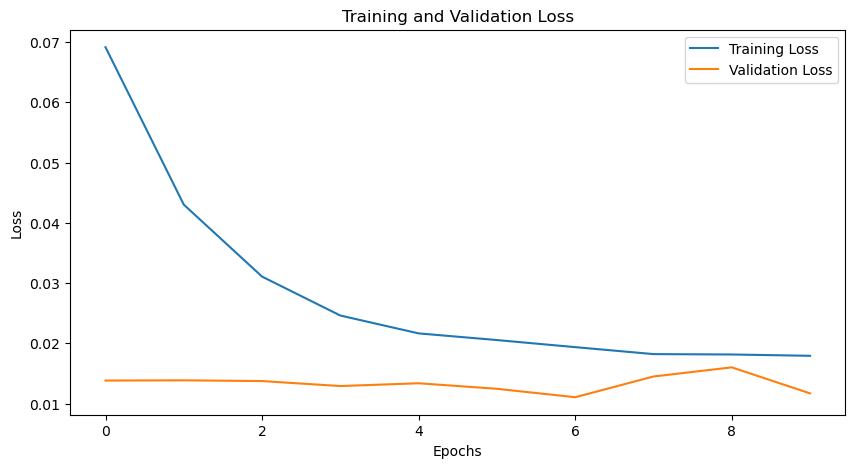

In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings

# Prepare Data
# dataset = FinancialDataset(first_month_data[:1000])
# dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

train_dataset = FinancialDataset(train_data[train_data["permno_id"] == "10104"])
val_dataset = FinancialDataset(validation_data[:100])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize Model
model = TransformerModel(
    input_dim=7 * 1 + 1,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

# for epoch in range(5):
#     for batch in dataloader:
#         optimizer.zero_grad()
#         output, _ = model(batch["features"])
#         loss = criterion(output, batch["target"])
#         # print(f'loss: {loss}')
#         loss.backward()
#         optimizer.step()

# print("Training Complete")

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

# num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Check for early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [39]:
dataloader = train_dataloader
dataset = train_dataset

In [41]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [42]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [43]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.06401443e-01, -1.17828466e-01,  4.66071725e-01,  4.80450094e-02,
          3.49758677e-02, -7.50906616e-02, -3.40168625e-02,  6.33494630e-02,
          1.37069291e-02,  1.90950055e-02, -1.37538016e-01, -2.33302489e-02,
          3.41873989e-02, -8.84401798e-03,  2.16402975e-03,  5.09603247e-02,
         -1.72422472e-02, -1.64792873e-02,  7.34988004e-02, -3.35998391e-03,
          9.95580256e-02,  8.62475693e-01,  5.81885092e-02,  7.31636807e-02,
          7.32199028e-02,  2.74223126e-02,  2.28309259e-02,  9.93379485e-03,
          6.97967485e-02,  1.71118937e-02, -2.55550122e+00,  3.65016535e-02,
         -8.52259994e-03, -7.37944245e-02,  2.70314179e-02,  3.80499887e+00,
          2.32870364e+00, -5.15432097e-02, -4.30974327e-02, -2.12268263e-01,
          3.48090753e-02,  4.49970253e-02, -2.26700038e-01, -4.62808013e-02,
         -5.88991567e-02, -7.99840391e-02, -3.52821574e-02,  8.89511034e-02,
         -2.31870916e-02, -5.33037148e-02,  6.40571862e-03,  2.44

#### Model Features Check

In [44]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  8.4490e-03,
          6.8240e-03,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  8.6340e-03,
          3.0460e-03,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  1.2769e-02,
          9.2920e-03,  1.3000e+02],
        ...,
        [ 7.0362e-03,  3.6530e-03,  8.6740e-03,  ..., -9.3130e-03,
         -6.7900e-03,  1.5700e+02],
        [ 1.9605e-02,  1.4844e-02,  1.8032e-02,  ...,  7.9830e-03,
          1.0099e-02,  1.5800e+02],
        [ 2.3780e-02,  1.5021e-02,  1.4210e-02,  ...,  3.6560e-03,
          2.3290e-03,  1.5900e+02]]), 'target': tensor([[ 1.2909e-02,  1.2909e-02,  3.9730e-01,  3.9730e-01,  8.6375e-02,
          8.6375e-02,  1.3961e-02,  1.3961e-02,  8.1100e-02,  1.0398e-01,
          1.2514e-01],
        [ 1.5745e-02,  1.5745e-02,  2.5376e-01,  2.5376e-01,  5.7886e-02,
          5.7886e-02,  1.0602e-02,  1.0602e-02,  1.0557e-01,  9.7839e-02,
          1.1782e-01],
  

In [45]:
batch["features"].shape

torch.Size([32, 641])

In [46]:
batch["target"].shape

torch.Size([32, 11])

In [47]:
len(batch["permno_id"])

32

In [48]:
batch["features"][:5]

tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  8.4490e-03,
          6.8240e-03,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  8.6340e-03,
          3.0460e-03,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  1.2769e-02,
          9.2920e-03,  1.3000e+02],
        [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  3.1830e-03,
         -1.4870e-03,  1.3100e+02],
        [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ..., -1.2551e-02,
          2.1730e-03,  1.3200e+02]])

In [50]:
model(batch["features"].to(device))

(tensor([[0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0

In [51]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  2.28968548e-02,  6.40400000e-03,  4.87200000e-03,
          5.90400000e-03,  7.98300000e-03,  9.80279522e-03,  4.04800000e-03,
          9.60000000e-04,  4.02100000e-03,  8.52000000e-04,  6.00095818e-03,
          9.58100000e-03,  6.72200000e-03,  6.19300000e-03,  2.91900000e-03,
          1.04670290e-02,  2.14200000e-03,  5.35400000e-03,  1.82900000e-03,
          5.82800000e-03,  5.49686452e-03, -2.63400000e-03, -2.70400000e-03,
          7.34000000e-04,  3.86000000e-04, -5.31409482e-03, -2.41900000e-03,
         -1.92800000e-03, -1.53900000e-03,  6.60500000e-03,  3.06928492e-03,
          6.46500000e-03,  9.75500000e-03,  8.26400000e-03,  7.22900000e-03,
          1.13750580e-02,  4.34800000e-03,  6.71800000e-03,  6.24600000e-03,
          1.21380000e-02,  1.61469568e-03, -6.57800000e-03, -6.44000000e-03,
         -4.55800000e-03, -2.58900000e-03,  1.36188412e-02,  8.18000000e-03,

In [52]:
np.array(stock_embeddings["10104"]).shape

(256,)

In [53]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
9268,2018-01-09,10104,511210.0,0.005497,0.005497,-0.002634,-0.002704,0.000734,0.000386,0.169896,0.169896,0.050064,0.050064,0.005407,0.005407,0.106685,0.171105,0.284743
9269,2018-01-10,10104,511210.0,-0.005314,0.005314,-0.002419,-0.001928,-0.001539,0.006605,0.218286,0.218286,0.074098,0.074098,0.004132,0.004132,0.084936,0.171392,0.285753
9270,2018-01-11,10104,511210.0,0.003069,0.003069,0.006465,0.009755,0.008264,0.007229,0.249912,0.249912,0.070934,0.070934,0.004184,0.004184,0.084245,0.171901,0.285767
9271,2018-01-12,10104,511210.0,0.011375,0.011375,0.004348,0.006718,0.006246,0.012138,0.218552,0.218552,0.016128,0.016128,0.006384,0.006384,0.076333,0.218201,0.288906
9272,2018-01-16,10104,511210.0,0.001615,0.001615,-0.006578,-0.006440,-0.004558,-0.002589,0.226701,0.226701,-0.038723,0.038723,0.010132,0.010132,0.073927,0.282714,0.291319


## Model-Compare

In [37]:
train_data[train_data["permno_id"] == "10104"]

,date,permno_id,naics,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,511210.0,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
1,2018-01-03,10104,511210.0,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
2,2018-01-04,10104,511210.0,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
3,2018-01-05,10104,511210.0,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
4,2018-01-08,10104,511210.0,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2022-12-23,10104,511210.0,0.004463,0.004463,0.002641,0.000440,0.005100,0.009920,0.240496,0.240496,0.130254,0.130254,0.030822,0.030822,0.167463,0.160461,0.193399
1255,2022-12-27,10104,511210.0,0.001607,0.001607,-0.005155,-0.010350,-0.004281,-0.002320,0.335016,0.335016,0.097081,0.097081,0.027325,0.027325,0.173581,0.200194,0.196869
1256,2022-12-28,10104,511210.0,-0.008059,0.008059,-0.011746,-0.011982,-0.012660,-0.006697,0.484128,0.484128,0.095868,0.095868,0.026012,0.026012,0.132557,0.201324,0.199301
1257,2022-12-29,10104,511210.0,0.013232,0.013232,0.026479,0.028541,0.018379,0.020048,0.393108,0.393108,0.098543,0.098543,0.021506,0.021506,0.143814,0.202965,0.196865


In [38]:
id = train_data['permno_id'].unique()
id[:5]

array(['10104', '10107', '10138', '10145', '10516'], dtype=object)

In [39]:
for i in id[::50]:
    print(f'permno_id: {i}')

permno_id: 10104
permno_id: 13688
permno_id: 17005
permno_id: 21936
permno_id: 30681
permno_id: 50876
permno_id: 64653
permno_id: 77274
permno_id: 81774
permno_id: 86745
permno_id: 89866
permno_id: 93246


### Model-1 (Past 7 days 1 feauture 1 target)

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.07918543331325054, Validation Loss: 0.04120431964596113
Epoch 2/10, Training Loss: 0.03726918362081051, Validation Loss: 0.017370761682589848
Epoch 3/10, Training Loss: 0.02842855006456375, Validation Loss: 0.012641644415756067
Epoch 4/10, Training Loss: 0.024262513127177955, Validation Loss: 0.010076836372415224
Epoch 5/10, Training Loss: 0.022051011910662055, Validation Loss: 0.010372990431884924
Epoch 6/10, Training Loss: 0.02068381083663553, Validation Loss: 0.010097604244947433
Epoch 7/10, Training Loss: 0.019416268495842815, Validation Loss: 0.010033862354854742
Epoch 8/10, Training Loss: 0.018475588946603238, Validation Loss: 0.010099095292389393
Epoch 9/10, Training Loss: 0.01846517911180854, Validation Loss: 0.01010216927776734
Epoch 10/10, Training Loss: 0.01772971374448389, Validation Loss: 0.010354495917757353
Training Complete


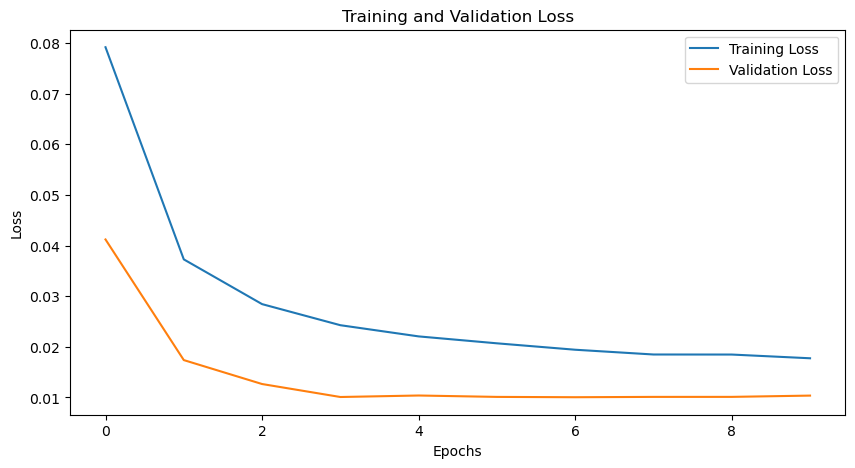

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.08348126308992505, Validation Loss: 0.017472025007009506
Epoch 2/10, Training Loss: 0.05463337074033916, Validation Loss: 0.024596918374300003
Epoch 3/10, Training Loss: 0.04272055230103433, Validation Loss: 0.016714490329225857
Epoch 4/10, Training Loss: 0.03671545060351491, Validation Loss: 0.01018497534096241
Epoch 5/10, Training Loss: 0.03347121875267476, Validation Loss: 0.013710803352296352
Epoch 6/10, Training Loss: 0.03177795223891735, Validation Loss: 0.017854406808813412
Epoch 7/10, Training Loss: 0.031107598450034857, Validation Loss: 0.013997665606439114
Epoch 8/10, Training Loss: 0.029936744831502438, Validation Loss: 0.015265056863427162
Epoch 9/10, Training Loss: 0.028921873355284334, Validation Loss: 0.015839713936050732
Early stopping triggered.
Training Complete


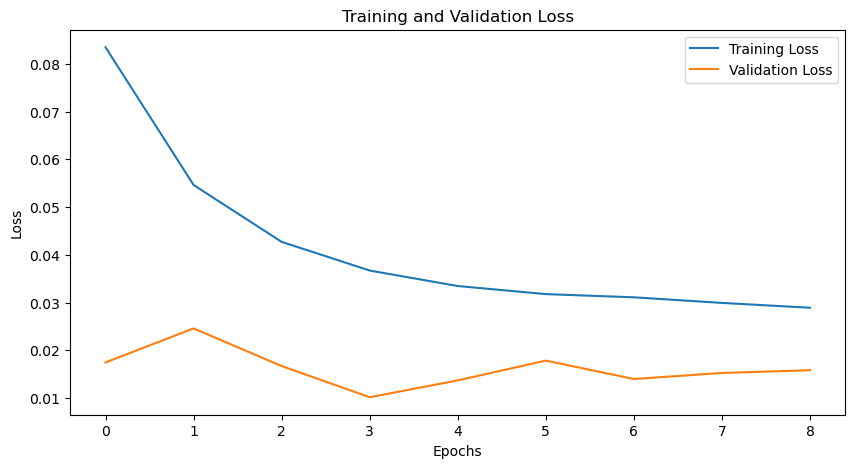

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.12897612750530243, Validation Loss: 0.06913699706395467
Epoch 2/10, Training Loss: 0.06540795024484396, Validation Loss: 0.04655516395966212
Epoch 3/10, Training Loss: 0.04916056664660573, Validation Loss: 0.03140696013967196
Epoch 4/10, Training Loss: 0.04108978835865855, Validation Loss: 0.01168108731508255
Epoch 5/10, Training Loss: 0.034933768259361384, Validation Loss: 0.010300363413989544
Epoch 6/10, Training Loss: 0.030430026771500706, Validation Loss: 0.011272937369843325
Epoch 7/10, Training Loss: 0.027931872056797147, Validation Loss: 0.013897194837530455
Epoch 8/10, Training Loss: 0.025201782258227466, Validation Loss: 0.015447438694536686
Epoch 9/10, Training Loss: 0.02289904176723212, Validation Loss: 0.0187947874267896
Epoch 10/10, Training Loss: 0.02236446461174637, Validation Loss: 0.01631501006583373
Early stopping triggered.
Training Complete


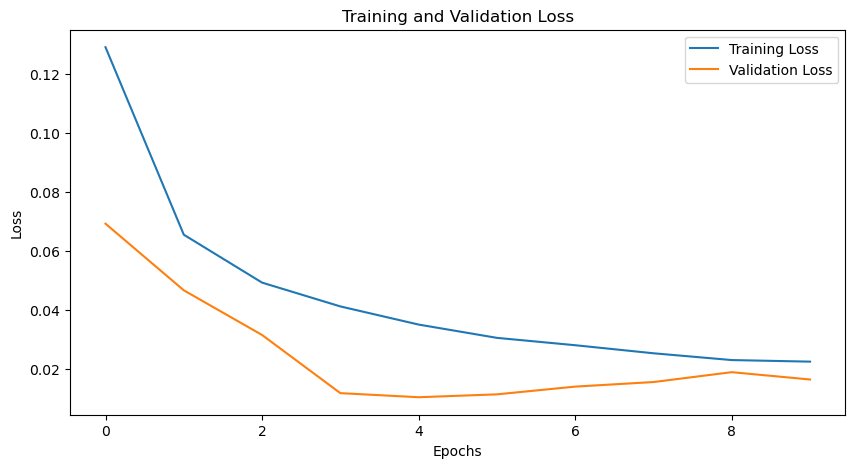

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.052880261186510326, Validation Loss: 0.013222838131090006
Epoch 2/10, Training Loss: 0.03883443968370557, Validation Loss: 0.010685342053572336
Epoch 3/10, Training Loss: 0.02835743143223226, Validation Loss: 0.011899244661132494
Epoch 4/10, Training Loss: 0.022295498941093683, Validation Loss: 0.010525446385145187
Epoch 5/10, Training Loss: 0.0188620510045439, Validation Loss: 0.011846717757483324
Epoch 6/10, Training Loss: 0.0175934717990458, Validation Loss: 0.016834087048967678
Epoch 7/10, Training Loss: 0.016871921811252834, Validation Loss: 0.013643304196496805
Epoch 8/10, Training Loss: 0.01565742832608521, Validation Loss: 0.013617894612252712
Epoch 9/10, Training Loss: 0.015538833942264319, Validation Loss: 0.015238977347811064
Early stopping triggered.
Training Complete


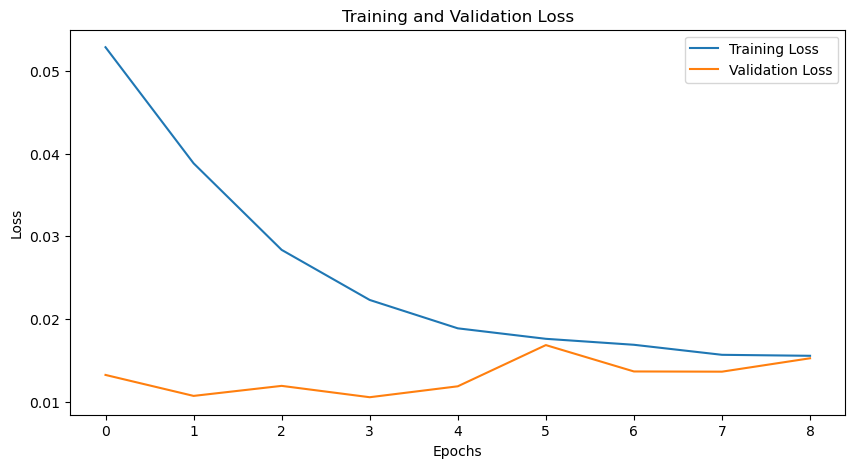

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.0874571979045868, Validation Loss: 0.029350051035483677
Epoch 2/10, Training Loss: 0.046800623461604116, Validation Loss: 0.012127692811191082
Epoch 3/10, Training Loss: 0.032977982284501196, Validation Loss: 0.010657904980083307
Epoch 4/10, Training Loss: 0.027844273298978806, Validation Loss: 0.010346117739876112
Epoch 5/10, Training Loss: 0.02373970744665712, Validation Loss: 0.010319767830272516
Epoch 6/10, Training Loss: 0.02272959644906223, Validation Loss: 0.01121468748897314
Epoch 7/10, Training Loss: 0.021775657823309303, Validation Loss: 0.013547008857131004
Epoch 8/10, Training Loss: 0.02110213376581669, Validation Loss: 0.016611325244108837
Epoch 9/10, Training Loss: 0.02025011647492647, Validation Loss: 0.01644828108449777
Epoch 10/10, Training Loss: 0.019762347172945737, Validation Loss: 0.019061739246050518
Early stopping triggered.
Training Complete


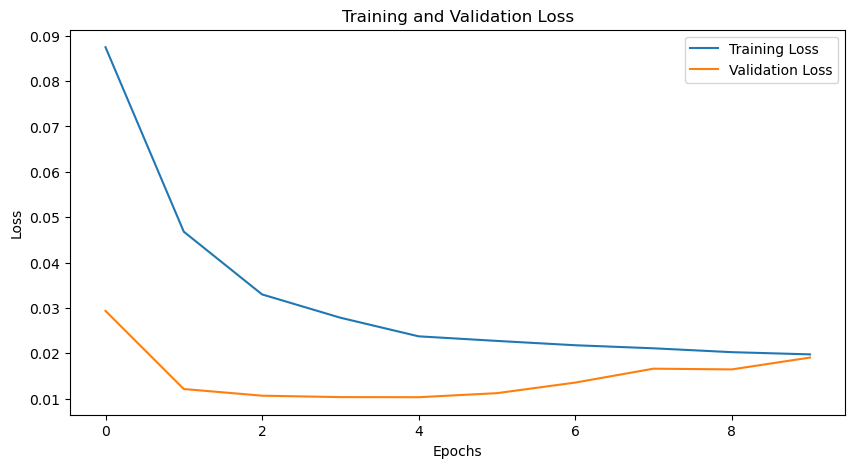

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.049540568795055154, Validation Loss: 0.011161881188551584
Epoch 2/10, Training Loss: 0.03443675097078085, Validation Loss: 0.01483177145322164
Epoch 3/10, Training Loss: 0.024970766436308623, Validation Loss: 0.015271664907534918
Epoch 4/10, Training Loss: 0.021547701908275485, Validation Loss: 0.01029636369397243
Epoch 5/10, Training Loss: 0.01842420711182058, Validation Loss: 0.01013109739869833
Epoch 6/10, Training Loss: 0.01718083245214075, Validation Loss: 0.010869819050033888
Epoch 7/10, Training Loss: 0.01593428887426853, Validation Loss: 0.01065586693584919
Epoch 8/10, Training Loss: 0.015387058677151799, Validation Loss: 0.010183961130678654
Epoch 9/10, Training Loss: 0.014683078089728952, Validation Loss: 0.010716892468432585
Epoch 10/10, Training Loss: 0.014180242246948183, Validation Loss: 0.010667908315857252
Early stopping triggered.
Training Complete


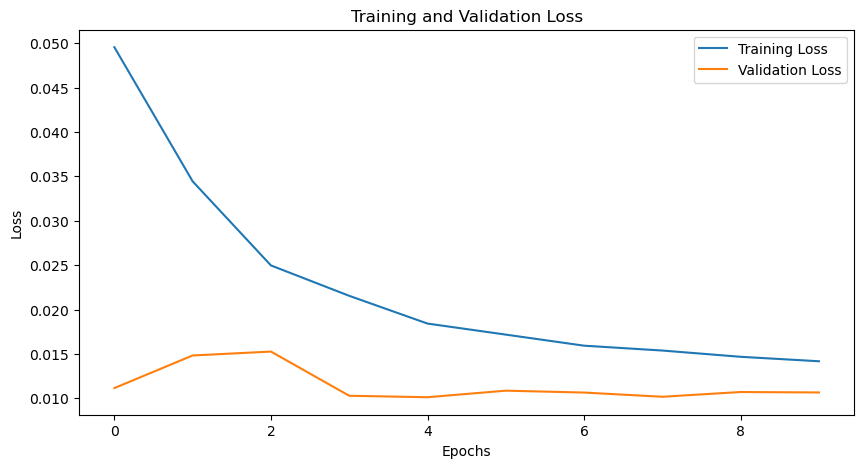

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.07077271956950426, Validation Loss: 0.012103357662757238
Epoch 2/10, Training Loss: 0.045928463153541085, Validation Loss: 0.010691568876306215
Epoch 3/10, Training Loss: 0.03476195065304637, Validation Loss: 0.011378151054183641
Epoch 4/10, Training Loss: 0.028137026727199553, Validation Loss: 0.010765040603776773
Epoch 5/10, Training Loss: 0.023118798108771443, Validation Loss: 0.010057284186283747
Epoch 6/10, Training Loss: 0.020435008872300386, Validation Loss: 0.010258500464260578
Epoch 7/10, Training Loss: 0.018223213381133974, Validation Loss: 0.010199064388871193
Epoch 8/10, Training Loss: 0.016799626871943474, Validation Loss: 0.013813634092609087
Epoch 9/10, Training Loss: 0.01603280850686133, Validation Loss: 0.010850463062524796
Epoch 10/10, Training Loss: 0.015077127027325332, Validation Loss: 0.012025100799898306
Early stopping triggered.
Training Complete


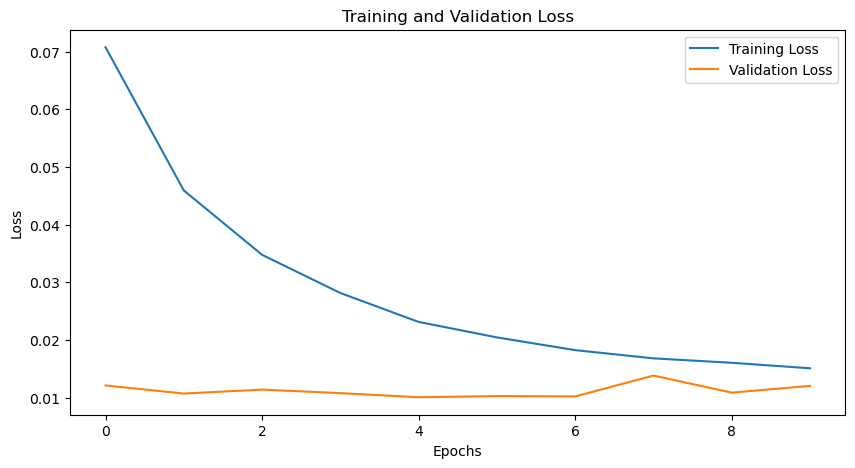

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.0739165760576725, Validation Loss: 0.022003086283802986
Epoch 2/10, Training Loss: 0.047344683390110734, Validation Loss: 0.012171442930897078
Epoch 3/10, Training Loss: 0.03513168008066714, Validation Loss: 0.012898461893200874
Epoch 4/10, Training Loss: 0.027695196541026236, Validation Loss: 0.012683381326496601
Epoch 5/10, Training Loss: 0.024900331953540446, Validation Loss: 0.010922761944433054
Epoch 6/10, Training Loss: 0.021335268416441976, Validation Loss: 0.010251396956543127
Epoch 7/10, Training Loss: 0.019667528010904788, Validation Loss: 0.011306850239634514
Epoch 8/10, Training Loss: 0.01858798312023282, Validation Loss: 0.015259658296902975
Epoch 9/10, Training Loss: 0.017940633464604616, Validation Loss: 0.015533284905056158
Epoch 10/10, Training Loss: 0.018316943664103746, Validation Loss: 0.01097344079365333
Training Complete


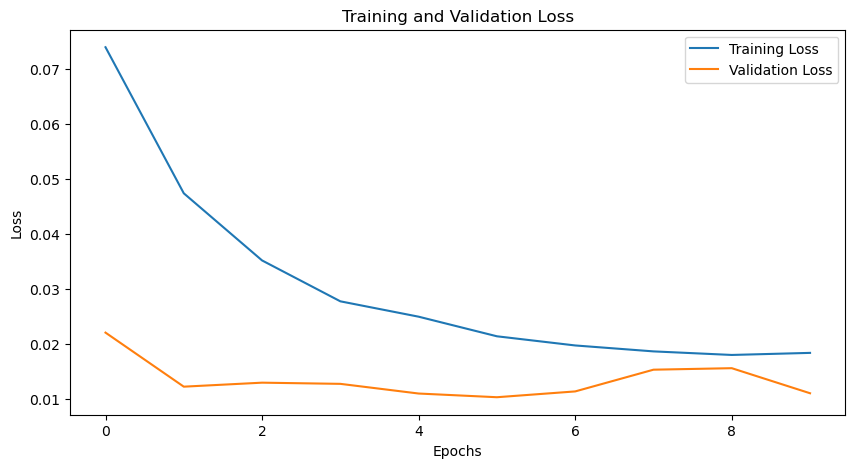

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.0758957034908235, Validation Loss: 0.011034692948063215
Epoch 2/10, Training Loss: 0.05552750509232283, Validation Loss: 0.01079712032030026
Epoch 3/10, Training Loss: 0.044743668660521506, Validation Loss: 0.013590700303514799
Epoch 4/10, Training Loss: 0.03428044109605253, Validation Loss: 0.010312942477564016
Epoch 5/10, Training Loss: 0.031180760310962796, Validation Loss: 0.012489796926577887
Epoch 6/10, Training Loss: 0.028813526127487422, Validation Loss: 0.013586006437738737
Epoch 7/10, Training Loss: 0.0279014325235039, Validation Loss: 0.014210172618428865
Epoch 8/10, Training Loss: 0.027072835061699153, Validation Loss: 0.01418660736332337
Epoch 9/10, Training Loss: 0.026638136757537723, Validation Loss: 0.01274760098507007
Early stopping triggered.
Training Complete


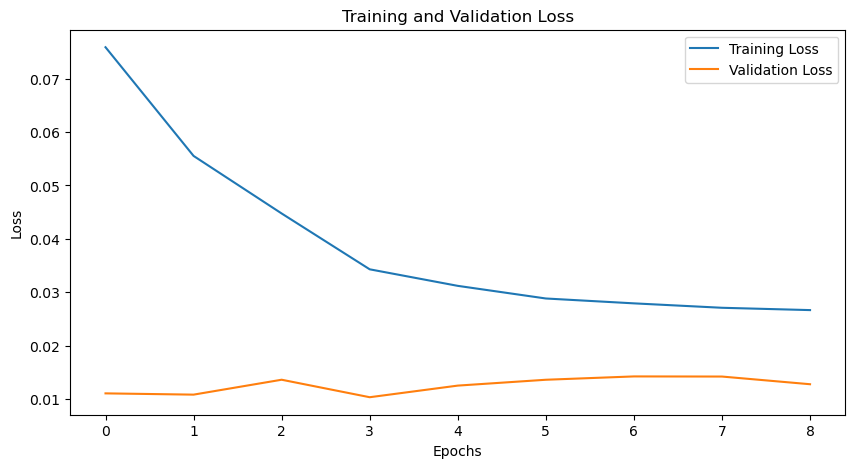

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.07947026463225484, Validation Loss: 0.011335369820396105
Epoch 2/10, Training Loss: 0.055285278055816886, Validation Loss: 0.016717522715528805
Epoch 3/10, Training Loss: 0.04347612150013447, Validation Loss: 0.010038841205338636
Epoch 4/10, Training Loss: 0.036664253054186705, Validation Loss: 0.010100100499888262
Epoch 5/10, Training Loss: 0.033957067085430025, Validation Loss: 0.013073891401290894
Epoch 6/10, Training Loss: 0.031207465659826995, Validation Loss: 0.011690008143583933
Epoch 7/10, Training Loss: 0.030675410060212016, Validation Loss: 0.012173125520348549
Epoch 8/10, Training Loss: 0.02963255373761058, Validation Loss: 0.010479155307014784
Early stopping triggered.
Training Complete


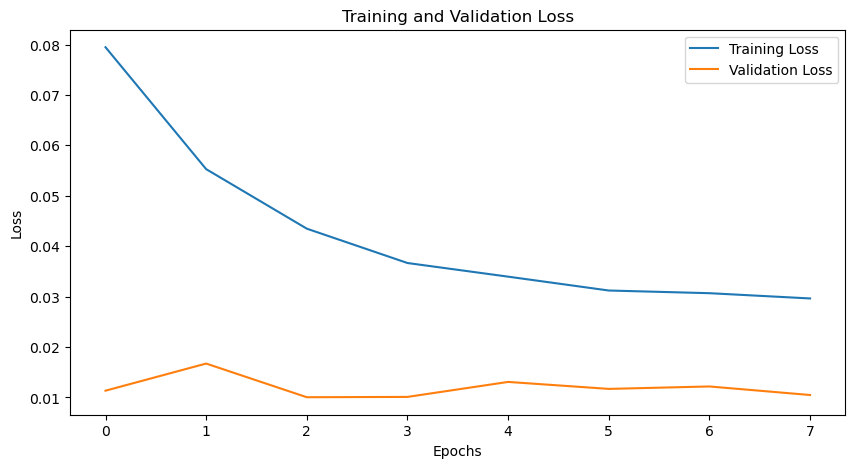

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.08427659142762423, Validation Loss: 0.022909629469116528
Epoch 2/10, Training Loss: 0.046476900251582264, Validation Loss: 0.010037930061419805
Epoch 3/10, Training Loss: 0.034746621176600455, Validation Loss: 0.00994804035872221
Epoch 4/10, Training Loss: 0.027063739066943527, Validation Loss: 0.012865127064287663
Epoch 5/10, Training Loss: 0.023689294001087546, Validation Loss: 0.01391944382339716
Epoch 6/10, Training Loss: 0.021676612086594105, Validation Loss: 0.012274034321308136
Epoch 7/10, Training Loss: 0.020354864094406365, Validation Loss: 0.014032603551944097
Epoch 8/10, Training Loss: 0.019489908823743463, Validation Loss: 0.014621271751821041
Early stopping triggered.
Training Complete


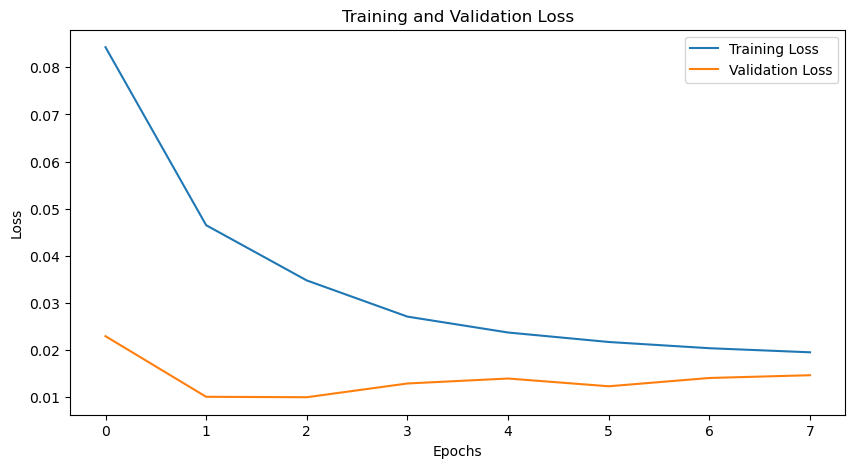

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.09224023139104247, Validation Loss: 0.039138201624155045
Epoch 2/10, Training Loss: 0.05212745377793908, Validation Loss: 0.010591135049859682
Epoch 3/10, Training Loss: 0.04111584676429629, Validation Loss: 0.012705640867352486
Epoch 4/10, Training Loss: 0.035451795998960735, Validation Loss: 0.01303815965851148
Epoch 5/10, Training Loss: 0.03165772007778287, Validation Loss: 0.017665402963757515
Epoch 6/10, Training Loss: 0.02998968414030969, Validation Loss: 0.012141867851217588
Epoch 7/10, Training Loss: 0.028908182261511685, Validation Loss: 0.013877782970666885
Early stopping triggered.
Training Complete


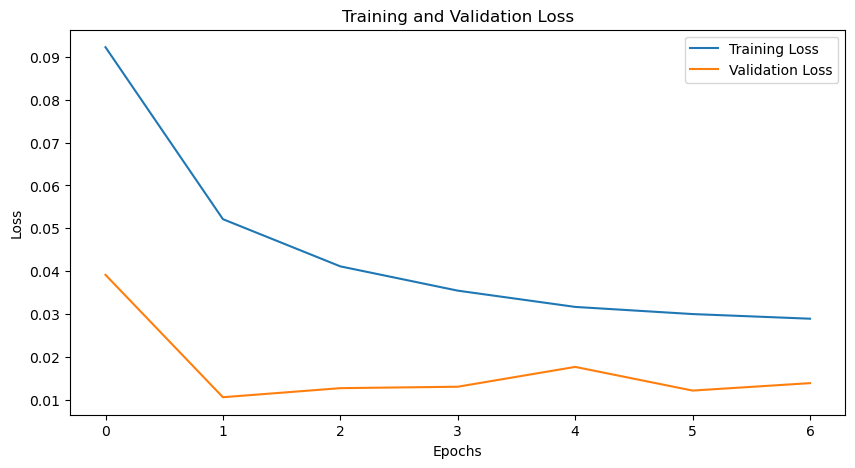

In [44]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings

# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    print(f'Training for permno_id: {permno_id}')

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()
    
    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()
    
    # print("Training Complete")
    
    train_losses = []
    val_losses = []
    
    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))
    
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
    
        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    print("Training Complete")
    
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    
    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())
    
    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [45]:
stock_embeddings

{'10104': array([ 0.9077693 , -0.38170952, -0.63233656, -0.12213374,  0.3696068 ,
         1.7215377 ,  0.25091532,  0.14060627,  0.832205  ,  0.3282388 ,
         0.324798  , -1.0063136 , -1.0203053 ,  0.62516713,  0.5687154 ,
        -0.16450356,  0.3890337 , -0.29008302,  1.5966971 ,  1.7380277 ,
         0.696494  ,  0.04194862,  0.37126955, -1.0914236 ,  0.56735486,
        -0.50733787, -0.00744544, -0.2694785 , -0.7755795 , -0.28638804,
        -1.0866902 ,  0.6400075 , -2.4547358 , -0.34678355,  0.7664026 ,
        -0.2866899 , -0.6690222 , -0.82639897, -0.6150593 ,  0.44554836,
         0.98486155, -1.200406  , -1.1444367 ,  1.1942736 ,  0.9831541 ,
        -0.23494737, -1.641865  , -0.6185287 , -0.4587314 , -0.7403815 ,
        -0.42831254, -0.24612336, -1.1012973 , -0.13358822, -0.26003686,
        -0.72835094, -1.0958632 ,  0.07684942, -0.0408123 , -0.07374593,
         1.9571428 , -0.4374496 , -2.5775259 ,  0.6821568 ,  0.5986328 ,
         1.3893646 ,  0.05640723, -0.16889

In [48]:
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.0000005 , -0.02341226,  0.00603095, -0.01878552,  0.07634288,
        -0.02448368,  0.04533082, -0.06582549,  0.0646541 ,  0.03485626,
        -0.05263662, -0.00868683],
       [-0.02341226,  0.9999999 , -0.05058887,  0.04864826,  0.20168361,
        -0.06811924,  0.06900473,  0.01429913,  0.05605198, -0.05007672,
         0.03154162, -0.01945102],
       [ 0.00603095, -0.05058887,  0.99999994,  0.054162  , -0.04721414,
        -0.05637546, -0.06127907, -0.0448039 ,  0.07741497,  0.03951667,
        -0.03575544,  0.1170498 ],
       [-0.01878552,  0.04864826,  0.054162  ,  0.9999997 , -0.0103162 ,
         0.02018012, -0.00437266, -0.14001732,  0.05263589,  0.12434519,
         0.02067832,  0.02965417],
       [ 0.07634288,  0.20168361, -0.04721414, -0.0103162 ,  1.0000004 ,
        -0.05381298,  0.01968997,  0.06040927, -0.03389465, -0.02664903,
        -0.00578395, -0.01475798],
       [-0.02448368, -0.06811924, -0.05637546,  0.02018012, -0.05381298,
         0.9999999 ,  

## Clustering the Stocks

#### K-means & squared Euclidean distances

Cluster 0: ['10107', '10516', '11308', '11403', '11404', '11600', '11762', '11891', '11955', '12345', '12449', '12490', '12558', '13210', '13379', '13407', '13628', '13788', '13963', '13964', '14541', '14702', '14763', '14776', '15291', '15408', '15720', '15998', '16000', '16851', '16968', '17005', '17144', '17478', '17750', '18163', '21178', '21186', '21792', '21936', '23660', '23931', '24010', '24205', '24643', '25081', '25320', '25419', '25582', '25953', '27633', '28484', '29946', '30681', '35044', '36003', '39917', '40272', '40539', '41080', '41355', '43350', '43449', '45751', '46674', '46886', '50876', '52038', '56274', '58683', '59176', '59300', '59328', '60206', '60506', '61241', '61735', '64186', '64282', '64311', '64936', '64995', '65541', '66093', '66181', '69032', '72726', '75591', '75607', '75825', '76076', '76082', '76709', '76744', '76841', '77037', '77129', '77182', '77649', '77661', '78981', '78987', '79637', '79881', '80080', '80100', '80286', '80329', '81540', '81696'

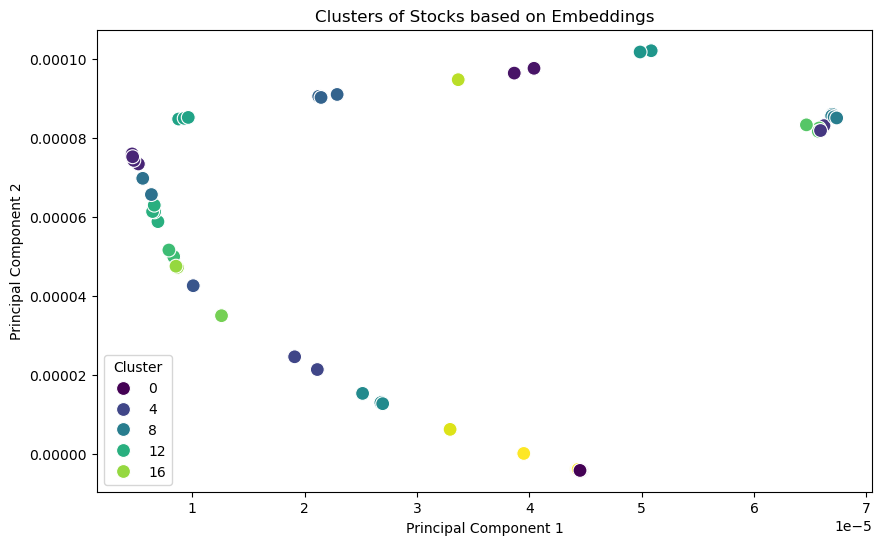

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-means clustering
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Create a dataframe to store permno_id and their corresponding cluster

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Print permno_id in each cluster
for cluster in range(n_clusters):
    cluster_members = cluster_df[cluster_df["cluster"] == cluster]["permno_id"].tolist()
    print(f"Cluster {cluster}: {cluster_members}")

# Plot the clusters using PCA for dimensionality reduction

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
    s=100,
)
plt.title("Clusters of Stocks based on Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & AgglomerativeClustering

- In this approach, you directly apply Agglomerative Clustering to the original embeddings.
- The metric='cosine' parameter tells the algorithm to use cosine distance (1 - cosine similarity) as the metric for clustering.
- The linkage='average' parameter specifies that the distance between clusters is the average distance between points in the clusters.

Cluster 0: ['20057', '20189']
Cluster 1: ['17334', '19285', '19286']
Cluster 2: ['18484', '18576']
Cluster 3: ['17685', '17700', '82686']
Cluster 4: ['18312', '76201', '79996', '82759']
Cluster 5: ['22623', '77668']
Cluster 6: ['18911', '18940', '79265']
Cluster 7: ['11896', '18592', '18724', '18726']
Cluster 8: ['12650', '18420', '18421', '18428']
Cluster 9: ['22206', '22265', '90441', '90442']
Cluster 10: ['88436']
Cluster 11: ['10909']
Cluster 12: ['19751']
Cluster 13: ['11552', '91063']
Cluster 14: ['17341']
Cluster 15: ['22976', '25778', '89757']
Cluster 16: ['18143']
Cluster 17: ['17307']
Cluster 18: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11404', '11600', '11618', '11674', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12558', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13511'

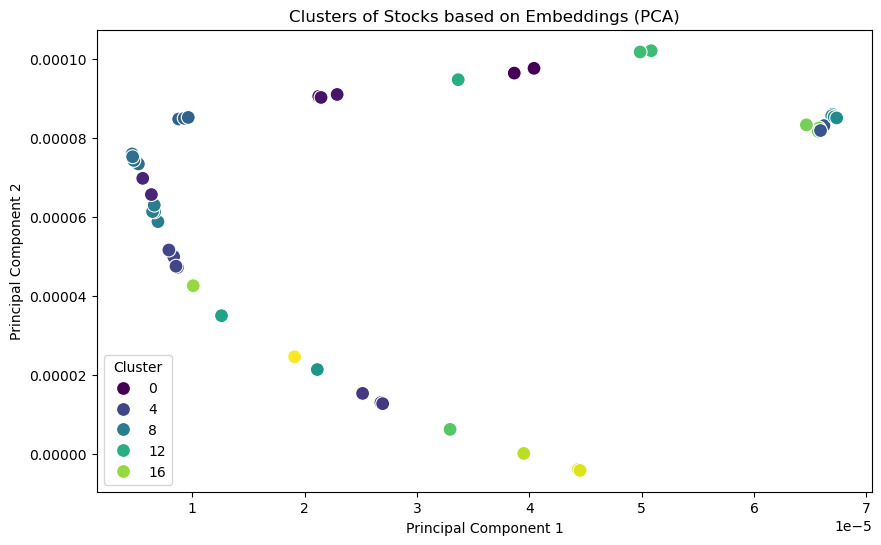

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings = np.array(list(stock_embeddings.values()))

# Perform Agglomerative Clustering with cosine affinity
n_clusters = 20
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric="cosine", linkage="average")
labels = clustering.fit_predict(embeddings)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(stock_embeddings.keys(), labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(stock_embeddings.keys()):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & Cosine Similarity
1. Cosine Similarity Transformation:  
    - Here, you first compute the cosine similarity matrix from the embeddings.
    - This matrix represents the cosine similarity between each pair of embeddings.
    - The similarity matrix is then used as the input to the KMeans clustering algorithm.  
2. KMeans Clustering:
    - KMeans is applied to the cosine similarity matrix, treating each similarity score as a feature.
    - This approach uses the similarity scores rather than the original embeddings to determine the clusters.

Cluster 0: ['64653']
Cluster 1: ['81774', '89866']
Cluster 2: ['10104', '13688', '30681']
Cluster 3: ['17005', '50876', '93246']
Cluster 4: ['21936', '77274', '86745']


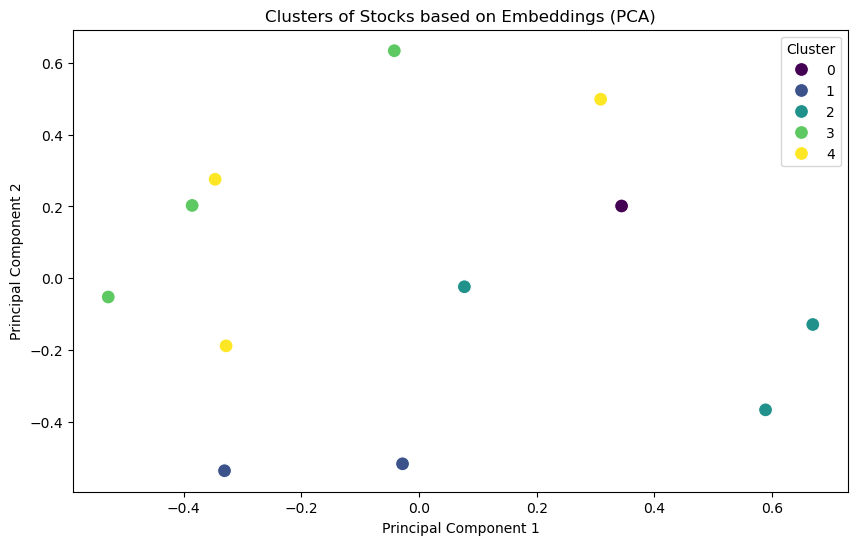

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### Difference - AgglomerativeClustering and Cosine Similarity

Approach 1: Transforming Embeddings using Cosine Similarity and then Applying KMeans  
Approach 2: Agglomerative Clustering with Cosine Affinity  

1. Cosine Similarity Matrix vs. Original Embeddings:
    - Approach 1: Uses the cosine similarity matrix as the input for clustering. This means the clustering is based on the similarity scores between embeddings.  
    - Approach 2: Uses the original embeddings directly with cosine distance as the metric. The clustering is based on the pairwise cosine distances between embeddings.  
2. Clustering Algorithm:
    - Approach 1: Uses KMeans, which is a centroid-based algorithm. It aims to partition the data into clusters such that the sum of the squared distances from each point to its assigned centroid is minimized.  
    - Approach 2: Uses Agglomerative Clustering, which is a hierarchical clustering method. It builds a tree-like structure of clusters by merging pairs of clusters iteratively based on the specified linkage criterion and distance metric.  
3. Distance Metric Usage:  
    - Approach 1: Cosine similarity is precomputed and used as the input for clustering.  
    - Approach 2: Cosine distance is used directly within the clustering algorithm.|

#### Cosine Similarity Matrix

In [47]:
cosine_sim_matrix

array([[ 1.0000005 , -0.02341226,  0.00603095, -0.01878552,  0.07634288,
        -0.02448368,  0.04533082, -0.06582549,  0.0646541 ,  0.03485626,
        -0.05263662, -0.00868683],
       [-0.02341226,  0.9999999 , -0.05058887,  0.04864826,  0.20168361,
        -0.06811924,  0.06900473,  0.01429913,  0.05605198, -0.05007672,
         0.03154162, -0.01945102],
       [ 0.00603095, -0.05058887,  0.99999994,  0.054162  , -0.04721414,
        -0.05637546, -0.06127907, -0.0448039 ,  0.07741497,  0.03951667,
        -0.03575544,  0.1170498 ],
       [-0.01878552,  0.04864826,  0.054162  ,  0.9999997 , -0.0103162 ,
         0.02018012, -0.00437266, -0.14001732,  0.05263589,  0.12434519,
         0.02067832,  0.02965417],
       [ 0.07634288,  0.20168361, -0.04721414, -0.0103162 ,  1.0000004 ,
        -0.05381298,  0.01968997,  0.06040927, -0.03389465, -0.02664903,
        -0.00578395, -0.01475798],
       [-0.02448368, -0.06811924, -0.05637546,  0.02018012, -0.05381298,
         0.9999999 ,  

#### check negative value in cosine_sim_matrix

In [56]:
# Check for negative values in the cosine similarity matrix
negative_values = cosine_sim_matrix[cosine_sim_matrix < 0]

if len(negative_values) > 0:
    print(f"There are {len(negative_values)} negative values in the cosine similarity matrix.")
    print(negative_values)
else:
    print("There are no negative values in the cosine similarity matrix.")

There are no negative values in the cosine similarity matrix.


In [57]:
# Find the maximum value in the cosine similarity matrix
max_value = np.max(cosine_sim_matrix)
print(f"Max value: {max_value}")

# Find the minimum value in the cosine similarity matrix
min_value = np.min(cosine_sim_matrix)
print(f"Min value: {min_value}")

Max value: 1.000000238418579
Min value: 0.9999996423721313


Sample embeddings:
[[-0.10113669 -0.13117969  4.643764   -0.09728476 -0.13188404 -0.11414704
  -0.10199591 -0.09753642  5.2008724  -0.13804568 -0.10543156 -0.12181271
  -0.11092354 -0.10593085 -0.10379755 -0.12611543 -0.13012108 -0.10574751
  -0.10132074 -0.09109034 -0.1217372  -0.10508449 -0.12317963 -0.11023221
  -0.12776662 -0.10637771 -0.11569362 -0.1243245  -0.12921163 -0.12488127
  -0.13221206 -0.12708518 -0.34985635 -0.12901476 -0.12900788 -0.10293555
  -0.10689097 -0.12761888 -0.1141796  -0.13812514 -0.13206193 -0.10620784
  -0.13905913  0.5077686  -0.11439564 -0.10097685 -0.10466886 -0.14279886
  -0.11103318 -0.12519583 -0.12899232 -0.09925667 -0.12949999 -0.1302237
  -0.0958822  -0.11069038 -0.12490238 -0.13115653 -0.13030057 -0.10379748
  -0.099494   -0.12419097 -0.12821966 -3.0186055 ]
 [-0.10118653 -0.13112779  4.6437497  -0.09723199 -0.13183765 -0.11420897
  -0.10202868 -0.09758627  5.200917   -0.1380884  -0.10544573 -0.12179092
  -0.11095989 -0.10586552 -0.10382174 -0.12

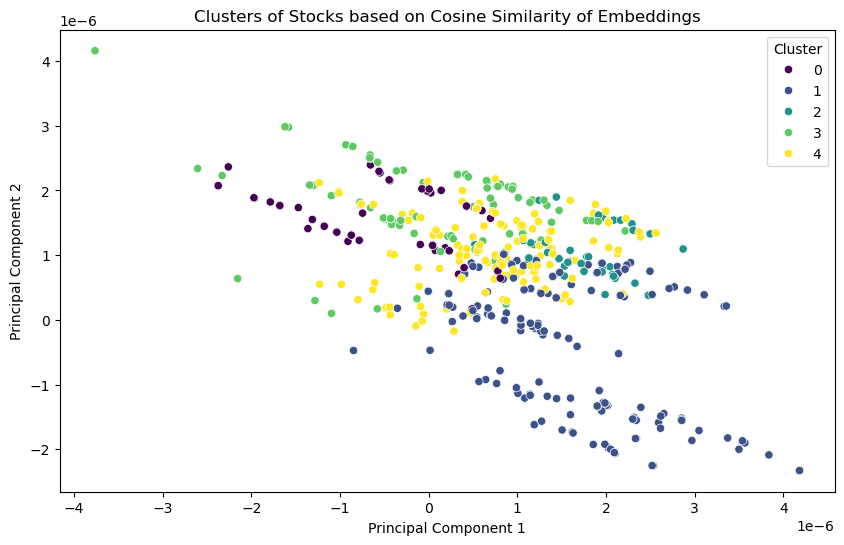

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Check the embeddings to ensure they have diverse values
print("Sample embeddings:")
print(embeddings_array[:5])

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Check if there are any negative values in the cosine similarity matrix
print("Cosine Similarity Matrix Sample:")
print(cosine_sim_matrix[:5, :5])

# Ensure there are negative values
if np.any(cosine_sim_matrix < 0):
    print("Cosine similarity matrix contains negative values.")
else:
    print("Cosine similarity matrix does not contain negative values.")

# Perform K-means clustering
n_clusters = 5  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cosine_sim_matrix)

# Create a dataframe to store permno_id and their corresponding cluster
import pandas as pd

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Plot the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
)
plt.title("Clusters of Stocks based on Cosine Similarity of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Clustering Stocks Return

In [51]:
list(permno_id_to_cluster.items())[:10]

[('10104', 14),
 ('10107', 1),
 ('10138', 6),
 ('10145', 1),
 ('10516', 6),
 ('10696', 1),
 ('10909', 9),
 ('11308', 1),
 ('11403', 11),
 ('11404', 1)]

In [52]:
df_clustering = df

# Add cluster_id to the original data
df_clustering["cluster_id"] = df_clustering["permno_id"].map(permno_id_to_cluster)
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,equal_weighted_return,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.011232,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005103,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005272,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.003880,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.000584,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.007676,0.001660,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11
7658918,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.009674,0.004232,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11
7658919,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.005276,0.001430,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11
7658920,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.002042,0.000370,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11


#### 1. Calculate the log returns of the clustering corresponding to each stock, calculated using the weighted average stock prices in the clustering

In [53]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"]).agg({"weighted_price": "sum", "market_cap": "sum"}).reset_index()
)

# Then, calculate the weighted average price
grouped["weighted_avg_price"] = grouped["weighted_price"] / grouped["market_cap"]

# Then, calculate the log return for each cluster_id
grouped["weighted_avg_price_shifted"] = grouped.groupby("cluster_id")["weighted_avg_price"].shift(1)
grouped["cluster_weighted_avg_log_return"] = (
    np.log(grouped["weighted_avg_price"] / grouped["weighted_avg_price_shifted"]).fillna(0)
).round(6)

grouped

,cluster_id,date,weighted_price,market_cap,weighted_avg_price,weighted_avg_price_shifted,cluster_weighted_avg_log_return
0,0,2018-01-02,2.724403e+11,2.031136e+09,134.131957,NaN,0.000000
1,0,2018-01-03,2.745722e+11,2.039307e+09,134.639972,134.131957,0.003780
2,0,2018-01-04,2.759041e+11,2.046690e+09,134.805061,134.639972,0.001225
3,0,2018-01-05,2.811508e+11,2.065263e+09,136.133184,134.805061,0.009804
4,0,2018-01-08,2.817589e+11,2.064198e+09,136.497987,136.133184,0.002676
...,...,...,...,...,...,...,...
25417,19,2018-12-17,5.266052e+09,5.449143e+07,96.640000,98.220000,-0.016217
25418,19,2018-12-18,5.092051e+09,5.358362e+07,95.030000,96.640000,-0.016800
25419,19,2018-12-19,5.174904e+09,5.401779e+07,95.800000,95.030000,0.008070
25420,19,2018-12-20,4.806810e+09,5.206119e+07,92.330000,95.800000,-0.036894


In [54]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_weighted_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760


In [55]:
df_clustering["cluster_weighted_avg_log_return"]

0         0.000000
1         0.021764
2         0.002430
3         0.016969
4         0.005760
            ...   
809878    0.002708
809879    0.008723
809880    0.009865
809881   -0.016219
809882   -0.008694
Name: cluster_weighted_avg_log_return, Length: 809883, dtype: float64

#### 2. Calculate the log returns of the clustering corresponding to each stock, calculated using the arithmetic average stock prices in the clustering

In [56]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"])
    .agg({"close_price": "mean"})
    .reset_index()
    .rename(columns={"close_price": "avg_price"})
)

# Then, calculate the log return for each cluster_id
grouped["avg_price_Shifted"] = grouped.groupby("cluster_id")["avg_price"].shift(1)
grouped["cluster_simple_avg_log_return"] = (
    np.log(grouped["avg_price"] / grouped["avg_price_Shifted"]).fillna(0)
).round(6)

grouped

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cluster_id,date,avg_price,avg_price_Shifted,cluster_simple_avg_log_return
0,0,2018-01-02,108.603125,NaN,0.000000
1,0,2018-01-03,109.515313,108.603125,0.008364
2,0,2018-01-04,109.613282,109.515313,0.000894
3,0,2018-01-05,110.380938,109.613282,0.006979
4,0,2018-01-08,111.411250,110.380938,0.009291
...,...,...,...,...,...
25417,19,2018-12-17,96.640000,98.220000,-0.016217
25418,19,2018-12-18,95.030000,96.640000,-0.016800
25419,19,2018-12-19,95.800000,95.030000,0.008070
25420,19,2018-12-20,92.330000,95.800000,-0.036894


In [57]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_simple_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717


In [58]:
df_clustering["cluster_simple_avg_log_return"]

0         0.000000
1         0.012446
2         0.005958
3         0.007333
4         0.001717
            ...   
809878    0.012161
809879    0.004755
809880    0.001919
809881    0.000032
809882   -0.003015
Name: cluster_simple_avg_log_return, Length: 809883, dtype: float64

In [59]:
df_clustering.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [60]:
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11,0.002708,0.012161
809879,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11,0.008723,0.004755
809880,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11,0.009865,0.001919
809881,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11,-0.016219,0.000032


## Step 3 dataset  
Including stock daily log_returns from most similar and most opposite cosine similarity 

In [61]:
df_clustering = df_clustering[["date", "permno_id", "log_return"]]

In [62]:
df_clustering.dtypes

date          datetime64[ns]
permno_id             object
log_return           float64
dtype: object

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=2):
    # Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
    embeddings_list = []
    permno_ids = []
    n = 2

    for permno_id, embedding in stock_embeddings.items():
        permno_ids.append(permno_id)
        embeddings_list.append(embedding)

    # Convert the list of embeddings to a numpy array
    embeddings_array = np.array(embeddings_list)

    # Transform embeddings using cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_array)

    # Create a DataFrame for cosine similarity matrix for better handling
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=permno_ids, columns=permno_ids)

    base = df_clustering.copy()[["date", "permno_id", "log_return"]]

    # Initialize new columns for most similar and most opposite stocks and their log returns
    for i in range(1, n + 1):
        df_clustering[f"most_similar_{i}"] = np.nan
        # df_clustering[f"most_similar_{i}_log_return"] = np.nan
        df_clustering[f"most_opposite_{i}"] = np.nan
        # df_clustering[f"most_opposite_{i}_log_return"] = np.nan

    # Ensure the new columns are of the same type as 'permno_id'
    df_clustering = df_clustering.astype({f"most_similar_{i}": "object" for i in range(1, n + 1)})
    df_clustering = df_clustering.astype({f"most_opposite_{i}": "object" for i in range(1, n + 1)})

    # Fill new columns with permno_id and log_return of most similar and most opposite stocks
    for permno_id in df_clustering["permno_id"].unique():
        similarities = cosine_sim_df.loc[permno_id]
        sorted_similarities = similarities.sort_values(ascending=False)
        most_similar = sorted_similarities.index[1 : n + 1]  # First n most similar stocks
        most_opposite = sorted_similarities.index[-n:]  # Last n most opposite stocks

        for i in range(n):
            similar_permno_id = most_similar[i]
            opposite_permno_id = most_opposite[i]

            # Set the most similar and most opposite permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_similar_{i+1}"] = similar_permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_opposite_{i+1}"] = opposite_permno_id

    # Merge the similar stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_similar_{i}", "log_return": f"most_similar_{i}_log_return"}),
            on=["date", f"most_similar_{i}"],
            how="left",
        )

    # Merge the opposite stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_opposite_{i}", "log_return": f"most_opposite_{i}_log_return"}),
            on=["date", f"most_opposite_{i}"],
            how="left",
        )

    # for feat in ["most_similar_1", "most_opposite_1", "most_similar_2", "most_opposite_2"]:
    #     df_clustering = df_clustering.merge(base.rename(columns = {"permno_id": f"{feat}", "log_return": f"{feat}_log_return"}), on = ["date", feat], how = "left")

    return df_clustering


# Example usage:
df_clustering = find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=3)
df_clustering

/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_similar_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_opposite_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### Check

In [69]:
df_clustering[df_clustering["most_opposite_1"] == "90071"][["date", "permno_id", "most_opposite_1_log_return"]]

,date,permno_id,most_opposite_1_log_return
0,2018-01-02,10104,0.014639
1,2018-01-03,10104,-0.000692
2,2018-01-04,10104,-0.011493
3,2018-01-05,10104,0.006285
4,2018-01-08,10104,0.015199
...,...,...,...
809878,2023-12-22,93436,-0.001799
809879,2023-12-26,93436,0.016070
809880,2023-12-27,93436,0.008037
809881,2023-12-28,93436,0.012418


In [70]:
df_clustering[df_clustering["permno_id"] == "90071"][["date", "permno_id", "log_return"]]

,date,permno_id,log_return
736355,2018-01-02,90071,0.014639
736356,2018-01-03,90071,-0.000692
736357,2018-01-04,90071,-0.011493
736358,2018-01-05,90071,0.006285
736359,2018-01-08,90071,0.015199
...,...,...,...
737859,2023-12-22,90071,-0.001799
737860,2023-12-26,90071,0.016070
737861,2023-12-27,90071,0.008037
737862,2023-12-28,90071,0.012418


In [71]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                               0
permno_id                          0
log_return                         0
most_similar_1                     0
most_opposite_1                    0
most_similar_2                     0
most_opposite_2                    0
most_similar_1_log_return     510100
most_similar_2_log_return     537686
most_opposite_1_log_return      5155
most_opposite_2_log_return      8086
dtype: int64


In [72]:
any_nans = df_clustering.isna().any()
print(any_nans)

date                          False
permno_id                     False
log_return                    False
most_similar_1                False
most_opposite_1               False
most_similar_2                False
most_opposite_2               False
most_similar_1_log_return      True
most_similar_2_log_return      True
most_opposite_1_log_return     True
most_opposite_2_log_return     True
dtype: bool


In [73]:
any_nans_overall = df_clustering.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {any_nans_overall}")

Are there any NaN values in the DataFrame? True


In [74]:
rows_with_nans = df_clustering[df_clustering.isna().any(axis=1)]
rows_with_nans

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### replace NaN with 0 and add new columns to indicate them
1. If there was values in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 1.
2. If there was NaN in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 0.
3. replace the NaN with 0 for the columns "most_similar_log_return" and "most_opposite_log_return"

In [75]:
df_clustering

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


In [76]:
# Identify the columns that are related to most similar and most opposite log returns
similar_opposite_cols = [
    col for col in df_clustering.columns if "_log_return" in col and ("most_similar" in col or "most_opposite" in col)
]

# Add new columns to indicate if the value was NaN
for col in similar_opposite_cols:
    df_clustering[f"{col}_was_nan"] = np.where(df_clustering[col].isna(), 0, 1)

# Replace NaN values with 0 in the identified columns
df_clustering[similar_opposite_cols] = df_clustering[similar_opposite_cols].fillna(0)

# Example check
df_clustering

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return,most_similar_1_log_return_was_nan,most_similar_2_log_return_was_nan,most_opposite_1_log_return_was_nan,most_opposite_2_log_return_was_nan
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,0.0,0.000000,0.014639,0.011707,0,0,1,1
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,0.0,0.000000,-0.000692,0.008409,0,0,1,1
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,0.0,0.000000,-0.011493,-0.003173,0,0,1,1
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,0.0,0.000000,0.006285,0.004982,0,0,1,1
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,0.0,0.000000,0.015199,0.012794,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,0.0,-0.000298,-0.001799,0.004796,0,1,1,1
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,0.0,-0.006687,0.016070,0.007152,0,1,1,1
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,0.0,0.008278,0.008037,0.011061,0,1,1,1
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,0.0,-0.004778,0.012418,0.001920,0,1,1,1


In [77]:
df_clustering.columns

Index(['date', 'permno_id', 'log_return', 'most_similar_1', 'most_opposite_1',
       'most_similar_2', 'most_opposite_2', 'most_similar_1_log_return',
       'most_similar_2_log_return', 'most_opposite_1_log_return',
       'most_opposite_2_log_return', 'most_similar_1_log_return_was_nan',
       'most_similar_2_log_return_was_nan',
       'most_opposite_1_log_return_was_nan',
       'most_opposite_2_log_return_was_nan'],
      dtype='object')

In [78]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                                  0
permno_id                             0
log_return                            0
most_similar_1                        0
most_opposite_1                       0
most_similar_2                        0
most_opposite_2                       0
most_similar_1_log_return             0
most_similar_2_log_return             0
most_opposite_1_log_return            0
most_opposite_2_log_return            0
most_similar_1_log_return_was_nan     0
most_similar_2_log_return_was_nan     0
most_opposite_1_log_return_was_nan    0
most_opposite_2_log_return_was_nan    0
dtype: int64


## Save the cleaned df as csv & parquet


In [51]:
df_clustering.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.csv",
    index=False,
)
df_clustering.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")

In [52]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617


## Upload the parquet to s3


In [53]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean_clustering.parquet",
)

In [54]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean_clustering.parquet")

In [55]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617
